### Expedia Hotel Ranking

##### Problem statement
Each record of the dataset is an item in the search results and contains both search-level features (the input of the user, his country/city etc) and item-level features (information about the hotel). For each search in this dataset we observe which item was chosen at the end of the session.

Given these features, try and learn a model for hotel relevance.

##### Evaluation
Evaluation Metric is NDCG@50. Relevance is given by propbookingbool
(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

##### Data fields
srch_id: unique identifier for a search <br/>
visitor_id: visitor id used to submit the search <br/>
visitor_visit_nbr: count of visits for the user who has submitted the search <br/>
visitor_loc_country: country of the user who has submitted the search <br/>
visitor_loc_region: region of the user who has submitted the search <br/>
visitor_loc_city: city of the user who has submitted the search <br/>
visitor_wr_member: indicates if user is part of the hcom loyalty program<br/>
posa_continent: point of sale continent for a partiular search<br/>
posa_country: point of sale country for a particular search<br/>
srch_hcom_destination_id: destination id for a particular search <br/>
srch_dest_longitude: destination center longitude for a particular search<br/>
srch_dest_latitude: destination center latitude for a particular search<br/>
srch_ci: date of check-in of a search<br/>
srch_co: date of cehck-in of a search<br/>
srch_ci_day: day of check-in of a search<br/>
srch_co_day: day of check-out of a search<br/>
srch_los: length of stay of a search (check-in - check-out date)<br/>
srch_bw: booking window of a search (search-date - check-in date)<br/>
srch_adults_cnt: number of adults for a search <br/>
srch_children_cnt: number of children for a search <br/>
srch_rm_cnt: number of requested rooms on the search <br/>
mobile_bool: indicates if the search was submitted on a mobile browser<br/>
mobile_app: indicates if the search was submitted on a mobile app<br/>
device: identifies the device type type used for this search<br/>
currency: currency relevant for the point of sale the search was submitted form<br/>
position: the rank this property has been impressed on in a particular search<br/>
travelad_bool: indicates if a porperty in a search was a paid advert<br/>
dotd_bool: indicates if a property in a search was advertised as a special "daily deal"<br/>
price_without_discount_local: discounted property price in local (posa specific) currency<br/>
price_without_discount_usd: discounted property price in USD<br/>
price_with_discount_local: non-discounted property price in local currency<br/>
price_with_discount_usd: non-discounted property price in USD<br/>
imp_drr: name of the pricing/discount rule relevant for this property<br/>
click_bool: indicates if a property has been clicked in a particular search<br/>
booking_bool: indicates if property has been booken in a given search<br/>
prop_key: unique property identifier<br/>
prop_brand_bool: indicates if a property has a popular brand<br/>
prop_starrating: conventional hotel star rating (1-5 Stars)<br/>
prop_super_region: the super region this property belongs to (EMEA, APAC, NA, LATAM)<br/>
prop_continent: continent this property is located on (EU, NA, ...)<br/>
prop_country: country this property is located in<br/>
prop_market_id: higher granularity geo classification<br/>
prop_submarket_id: highest granularity geo classification<br/>
prop_room_capacity: max number of rooms this property has available<br/>
prop_review_score: average guest review score for this property<br/>
prop_review_count: count of customer reviews for this property<br/>
prop_hostel_bool: indicates if a property is a hostel<br/>
local_date: date for a particular search<br/>

### Import libs

In [2]:
import pandas as pd
import numpy as np
import os
import re
import warnings
from importlib import reload
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

from dataprep.dataprep import Analyser
from rank.ranker import Ranker
from pipeline.pipeline import Pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Get data

In [5]:
test_data = pd.read_csv(r'C:\Users\afragkoulis\PyCharmProjects\sortranking\data\test.csv')
train_data = pd.read_csv(r'C:\Users\afragkoulis\PyCharmProjects\sortranking\data\train.csv')

##### Configs

In [6]:
# ranker = Ranker()
# analyser = Analyser(train_data)
# pipeline = Pipeline()

##### Exploratory analysis

In [7]:
train_data.iloc[:,:].head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,...,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,3873959,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,80,4.7,43.0,0,2014-09-13
1,-1046322713,3214020,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98222,334,3.6,254.0,0,2014-09-13
2,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
3,-1046322713,3942297,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98278,10,0.0,0.0,1,2014-09-13
4,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831742 entries, 0 to 831741
Data columns (total 47 columns):
srch_id                              831742 non-null int64
prop_key                             831742 non-null int64
srch_date_time                       831742 non-null object
srch_visitor_id                      831742 non-null object
srch_visitor_visit_nbr               831742 non-null int64
srch_visitor_loc_country             831742 non-null object
srch_visitor_loc_region              831562 non-null object
srch_visitor_loc_city                831742 non-null object
srch_visitor_wr_member               394313 non-null object
srch_posa_continent                  354021 non-null object
srch_posa_country                    831742 non-null object
srch_hcom_destination_id             831742 non-null int64
srch_dest_longitude                  831742 non-null float64
srch_dest_latitude                   831742 non-null float64
srch_ci                              831742 non-nul

• Drop `srch_visitor_id` unique identifier <br/>
• Fill `posa_continent` nulls by generating a mapping between Countries and Continents from existing values <br/>
• `visitor_wr_member` are nulls essentially users not signed up? <br/>
• Convert `date_time`, `ci`, `co` to datetime object <br/>
• `srch_currency` fill mode of POSa<br/>
• Potentially high multicolinearity in currency/POSa/location fields, price fields, `srch_hcom_destination_id` and `prop_market_id`and mob/app indicators? <br/>
• Predict: `prop_booking_bool` <br/>
 <br/>
Minor fills: <br/>
• srch_visitor_loc_region (fill from city backwards) <br/>
• srch_visitor_loc_city (fill mode for region/country?) <br/>
• srch_adults_cnt (fill mode) <br/>
• prop_price_without_discount_local (fill with mean/median/mode for specific POSa/POSu vector) <br/>
• prop_price_without_discount_usd (fill with mean/median/mode for specific POSa/POSu vector) <br/>
• prop_price_with_discount_local (fill with mean/median/mode for specific POSa/POSu vector) <br/>
• prop_price_with_discount_usd (fill with mean/median/mode for specific POSa/POSu vector) <br/>
• prop_review_score (fill mean/median/mode ok here) <br/>
• prop_review_count (fill mean/median/mode ok here) <br/>

In [33]:
train_data.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,...,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,8.317420e+05,8.317420e+05,831742.000000,8.317420e+05,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,...,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831732.000000,831732.000000,831742.000000
mean,1.056124e+07,8.206936e+05,12.165431,1.194666e+06,-45.759613,40.417255,4.263995,3.682160,2.689988,35.455954,...,0.425870,0.028585,0.662960,3.589997,71708.060714,106500.747586,629.401151,4.020631,2164.589189,0.002896
std,1.232303e+09,1.142845e+06,31.484645,4.234226e+05,77.979597,6.043675,2.006931,2.128706,2.199806,49.973268,...,0.494475,0.166636,0.472699,0.866611,39069.697032,7370.403186,1580.685335,0.549570,3083.087088,0.053740
min,-2.147404e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,-1.043308e+09,2.561330e+05,1.000000,7.267840e+05,-115.172875,36.114666,2.000000,2.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,3.000000,60039.000000,98238.000000,143.000000,3.800000,304.000000,0.000000
50%,2.328319e+07,2.778660e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,...,0.000000,0.000000,1.000000,4.000000,95602.000000,109153.000000,305.000000,4.100000,935.000000,0.000000
75%,1.075904e+09,4.790390e+05,11.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,...,1.000000,0.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2556.000000,0.000000
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,...,1.000000,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


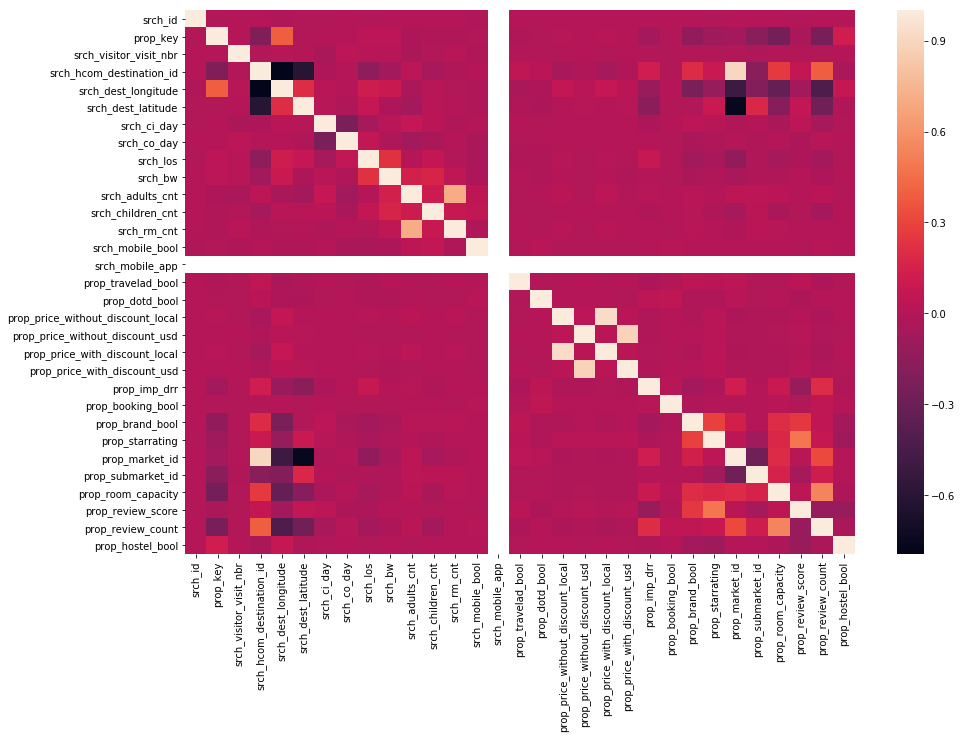

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax)

In [31]:
corr = train_data.corr()
cors = corr.abs().unstack().sort_values(ascending=False)
cors[29:45]

srch_id                            srch_id                              1.000000
prop_price_with_discount_local     prop_price_without_discount_local    0.923643
prop_price_without_discount_local  prop_price_with_discount_local       0.923643
prop_market_id                     srch_hcom_destination_id             0.902099
srch_hcom_destination_id           prop_market_id                       0.902099
prop_price_without_discount_usd    prop_price_with_discount_usd         0.886548
prop_price_with_discount_usd       prop_price_without_discount_usd      0.886548
srch_dest_longitude                srch_hcom_destination_id             0.792570
srch_hcom_destination_id           srch_dest_longitude                  0.792570
prop_market_id                     srch_dest_latitude                   0.764237
srch_dest_latitude                 prop_market_id                       0.764237
srch_adults_cnt                    srch_rm_cnt                          0.710629
srch_rm_cnt                 

In [37]:
sns.pairplot(train_data)

TypeError: pairplot() missing 1 required positional argument: 'data'

In [ ]:
# boxplots
train_data.plot(kind='box', subplots=True, layout=(11,3), sharex=False, sharey=False, figsize = (30,15)); 
plt.show();

##### Pipeline

### Submission
Suppose that in our test file we only have two searches:<br/>
• srchid 1234 with propkeys {546,678,678}<br/>
• srchid 2345 with propkeys {987,849,839,930}<br/>
<br/>
the your submission should look like:<br/>
srchid propkey<br/>
1234 546<br/>
1234 678<br/>
1234 890 <br/>
2345 930<br/>
2345 839<br/>
2345 987<br/>
2345 849<br/>
<br/>
ASC srchid, properties in DESC ranking order<br/>

In [1]:
pd.to_csv('submission.csv')

NameError: name 'pd' is not defined